In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df = pd.read_csv("../raw_data/cars_usa.csv")

In [16]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Process the 'engine' column

In [17]:
# Extract out the horsepower using RegEx
df['horsepower'] = df['engine'].str.extract(r'([0-9]+.0HP)', expand=True)

In [18]:
# Extract out the displacement using RegEx
df['displacement'] = df['engine'].str.extract(r'([0-9]+.[0-9]+L|[0-9]+.[0-9]+ Liter|[0-9]+L)', expand=True)

In [19]:
# Extract out the cylinder count using RegEx
df['cylinders'] = df['engine'].str.extract(r'(V[0-9]+|[0-9]+ Cylinder|I[0-9]+|H[0-9]+|V-[0-9]+|W[0-9]+)', expand=True)

In [20]:
# Replace the NaN values for the displacement and cylinder of electric cars with 0
df['displacement'] = df['displacement'].where(~df['engine'].str.contains('Electric Fuel System'), 0)
df['cylinders'] = df['cylinders'].where(~df['engine'].str.contains('Electric Fuel System'), 0)

In [21]:
# Remove the 'HP' at the end of each horsepower
df['horsepower'] = df['horsepower'].map(lambda i: str(i).rstrip('HP'))
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

In [22]:
# Remove the 'L' and 'Liter' at the end of each displacement
df['displacement'] = df['displacement'].map(lambda i: str(i).rstrip('L'))
df['displacement'] = df['displacement'].map(lambda i: str(i).rstrip(' Liter'))
df['displacement'] = pd.to_numeric(df['displacement'], errors='coerce')

In [23]:
# Remove similar text from the cylinders column
df['cylinders'] = df['cylinders'].map(lambda i: str(i).lstrip('V'))
df['cylinders'] = df['cylinders'].map(lambda i: str(i).lstrip('I'))
df['cylinders'] = df['cylinders'].map(lambda i: str(i).lstrip('H'))
df['cylinders'] = df['cylinders'].map(lambda i: str(i).lstrip('V-'))
df['cylinders'] = df['cylinders'].map(lambda i: str(i).lstrip('W'))
df['cylinders'] = df['cylinders'].map(lambda i: str(i).rstrip(' Cylinder'))
df['cylinders'] = pd.to_numeric(df['cylinders'], errors='coerce')

In [24]:
print(df['horsepower'].isna().sum())
print(df['displacement'].isna().sum())
print(df['cylinders'].isna().sum())

809
80
251


In [25]:
# Get the median HP, mode displacement and mode cylinder count for each brand
group = df.groupby('brand')
median_hp = group['horsepower'].median()
displacement_mode = group['displacement'].agg(pd.Series.mode)
cylinder_mode = group['cylinders'].agg(pd.Series.mode)

In [26]:
# Replace the NaN values with respective median and mode values
# Some brands' displacement and cylinder modes are empty or lists
# If the mode is a list, replace the NaN value with the first value of the list
# If the mode is empty, keep the NaN value as NaN
for idx in df.index:
    brand = df['brand'][idx]
    
    # Horsepower
    if str(df['horsepower'][idx]) == 'nan':
        df['horsepower'][idx] = median_hp[brand]
        
    # Displacement
    if str(df['displacement'][idx]) == 'nan':
        if type(displacement_mode[brand]) == np.float64:
            df['displacement'][idx] = displacement_mode[brand]
        else:
            if displacement_mode[brand].size != 0:
                df['displacement'][idx] = displacement_mode[brand][0]
            else:
                df['displacement'][idx] = 'NaN'
             
    # Cylinders
    if str(df['cylinders'][idx]) == 'nan':
        if type(cylinder_mode[brand]) == np.float64:
            df['cylinders'][idx] = cylinder_mode[brand]
        else:
            if cylinder_mode[brand].size != 0:
                df['cylinders'][idx] = cylinder_mode[brand][0]
            else:
                df['cylinders'][idx] = 'NaN'


C:\Users\Anugunj\AppData\Local\Temp\ipykernel_8088\1808836063.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['horsepower'][idx] = median_hp[brand]
C:\Users\Anugunj\AppData\Local\Temp\ipykernel_8088\1808836063.py:10: SettingWithCopyW

In [27]:
print(df['horsepower'].isna().sum())
print(df['displacement'].isna().sum())
print(df['cylinders'].isna().sum())

2
0
0


In [28]:
def split_transmission(transmission):
    # Identify the transmission type
    if 'CVT' in transmission:
        trans_type = 'CVT'
    elif 'Automatic' in transmission or 'A/T' in transmission or 'Dual' in transmission:
        trans_type = 'Automatic'
    elif 'Manual' in transmission or 'M/T' in transmission:
        trans_type = 'Manual'
    else:
        trans_type = 'Unknown'
    
    # Extract the number of gears
    gears = ''.join(filter(str.isdigit, transmission))
    if not gears:  # if gears is empty, set to 'Unknown'
        gears = np.nan
    else:
        gears = int(gears)  # Convert gears to integer
    
    return trans_type, gears

# Apply the function and create new columns
df['transmission_type'], df['gears'] = zip(*df['transmission'].apply(split_transmission))

In [29]:
print(df['transmission_type'].isna().sum())
print(df['gears'].isna().sum())

0
1833


In [30]:
# Group by both 'brand' and 'transmission_type' to find the smallest number of gears for each combination
smallest_gears_by_brand_and_transmission = df.groupby(['brand', 'transmission_type'])['gears'].median()

def fill_unknown_gears(row):
    if pd.isnull(row['gears']):
        # Use the combination of 'brand' and 'transmission_type' to get the smallest number of gears
        return smallest_gears_by_brand_and_transmission.get((row['brand'], row['transmission_type']), np.nan)
    return row['gears']

# Fill any remaining NaN values in 'gears' with defaults: 
# min_by_brand or 5 for Manual, min_by_brand or 6 for Automatic, 1 for CVT, 7 for DCT
for index, row in df[df['gears'].isna()].iterrows():
    if row['transmission_type'] == 'Automatic':
        df.at[index, 'gears'] = smallest_gears_by_brand_and_transmission.get((row['brand'], row['transmission_type']), 6)
    elif row['transmission_type'] == 'Manual':
        df.at[index, 'gears'] = smallest_gears_by_brand_and_transmission.get((row['brand'], row['transmission_type']), 5)
    elif row['transmission_type'] == 'CVT':
        df.at[index, 'gears'] = 1

In [31]:
print(df['transmission_type'].isna().sum())
print(df['gears'].isna().sum())

0
26


In [32]:
df = df.drop(columns=['model', 'clean_title', 'engine', 'transmission'])

In [33]:
df['price'] = df['price'].str.replace(',', '').str.replace('$', '').astype(float)
df['milage'] = df['milage'].str.replace(',', '').str.replace('mi.', '').astype(float)

In [34]:
min_val = df['price'].min()
max_val = df['price'].max()

labels = ['very low', 'low', 'medium', 'high', 'very high']
boundaries = [0, 20000, 40000, 60000, 80000, 1000000]
df['price'] = pd.cut(df['price'], bins=boundaries, labels=labels, include_lowest=True)

In [35]:
label_encodings_file = open("../clean_data/usa_label_encodings.txt", "w")

In [36]:
df['fuel_type'].fillna('Electric', inplace=True)
df = df[df['fuel_type'] != '–']
df = df[df['fuel_type'] != 'not supported']
df.dropna(inplace=True)

C:\Users\Anugunj\AppData\Local\Temp\ipykernel_8088\2867992147.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['fuel_type'].fillna('Electric', inplace=True)


## Little EDA

In [37]:
df.head()

,brand,model_year,milage,fuel_type,ext_col,int_col,accident,price,horsepower,displacement,cylinders,transmission_type,gears
0,Ford,2013,51000.0,E85 Flex Fuel,Black,Black,At least 1 accident or damage reported,very low,300.0,3.7,6.0,Automatic,6.0
1,Hyundai,2021,34742.0,Gasoline,Moonlight Cloud,Gray,At least 1 accident or damage reported,low,240.0,3.8,6.0,Automatic,8.0
2,Lexus,2022,22372.0,Gasoline,Blue,Black,None reported,medium,301.0,3.5,6.0,Automatic,8.0
3,INFINITI,2015,88900.0,Hybrid,Black,Black,None reported,very low,354.0,3.5,6.0,Automatic,7.0
4,Audi,2021,9835.0,Gasoline,Glacier White Metallic,Black,None reported,low,333.0,2.0,4.0,Automatic,8.0


Text(0.5, 0, 'Price')

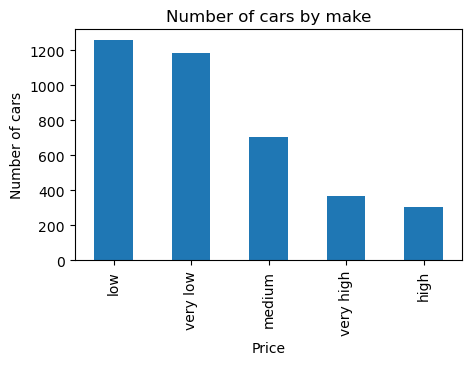

In [38]:
df['price'].value_counts().nlargest(40).plot(kind='bar', figsize=(5, 3))
plt.title("Number of cars by make")
plt.ylabel('Number of cars')
plt.xlabel('Price')

Text(0.5, 0, 'Accident Reported')

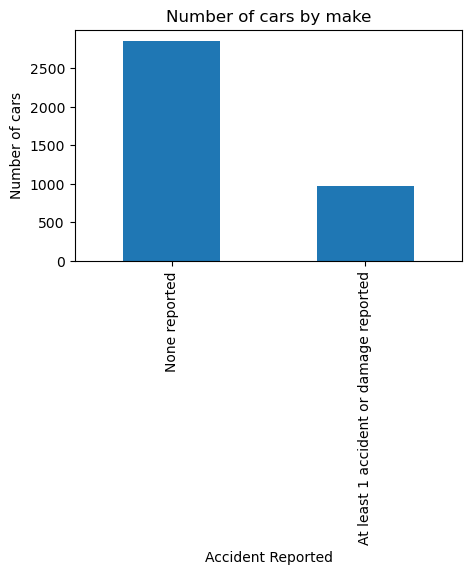

In [39]:
df['accident'].value_counts().nlargest(40).plot(kind='bar', figsize=(5, 3))
plt.title("Number of cars by make")
plt.ylabel('Number of cars')
plt.xlabel('Accident Reported')

Text(0.5, 0, 'Transmission')

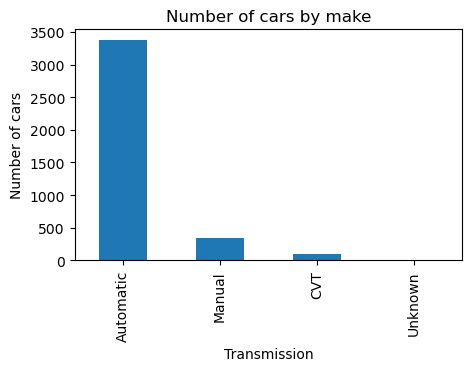

In [40]:
df['transmission_type'].value_counts().nlargest(40).plot(kind='bar', figsize=(5, 3))
plt.title("Number of cars by make")
plt.ylabel('Number of cars')
plt.xlabel('Transmission')

Text(0.5, 0, 'Horsepower')

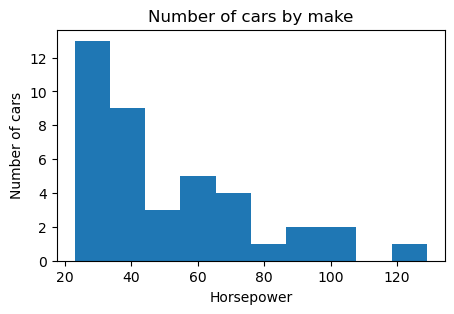

In [41]:
df['horsepower'].value_counts().nlargest(40).plot(kind='hist', figsize=(5, 3))
plt.title("Number of cars by make")
plt.ylabel('Number of cars')
plt.xlabel('Horsepower')

Text(0.5, 0, 'Brand')

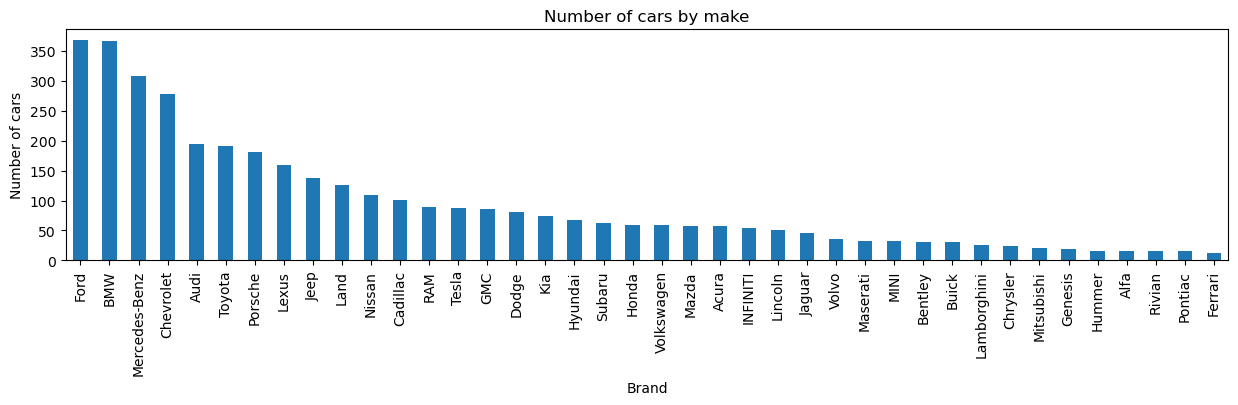

In [42]:
df['brand'].value_counts().nlargest(40).plot(kind='bar', figsize=(15, 3))
plt.title("Number of cars by make")
plt.ylabel('Number of cars')
plt.xlabel('Brand')

Text(0.5, 0, 'Fuel Type')

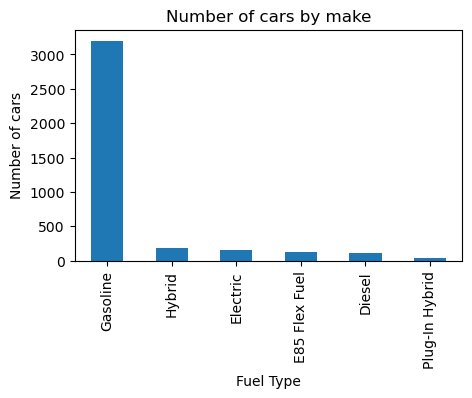

In [43]:
df['fuel_type'].value_counts().nlargest(40).plot(kind='bar', figsize=(5, 3))
plt.title("Number of cars by make")
plt.ylabel('Number of cars')
plt.xlabel('Fuel Type')

Text(0.5, 0, 'External Color')

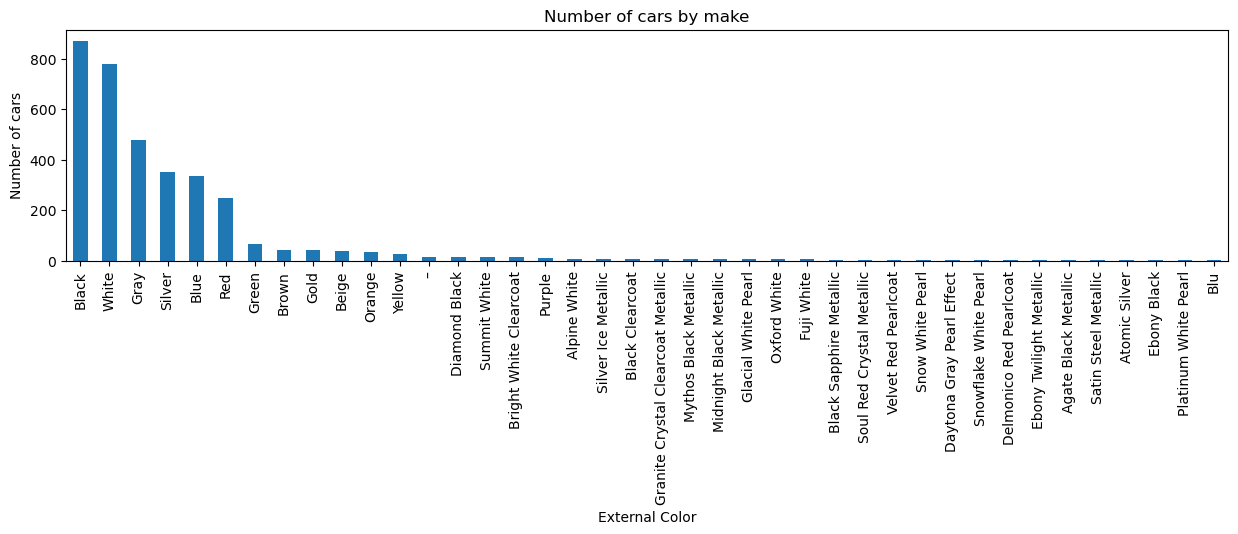

In [44]:
df['ext_col'].value_counts().nlargest(40).plot(kind='bar', figsize=(15, 3))
plt.title("Number of cars by make")
plt.ylabel('Number of cars')
plt.xlabel('External Color')

Text(0.5, 0, 'Internal Color')

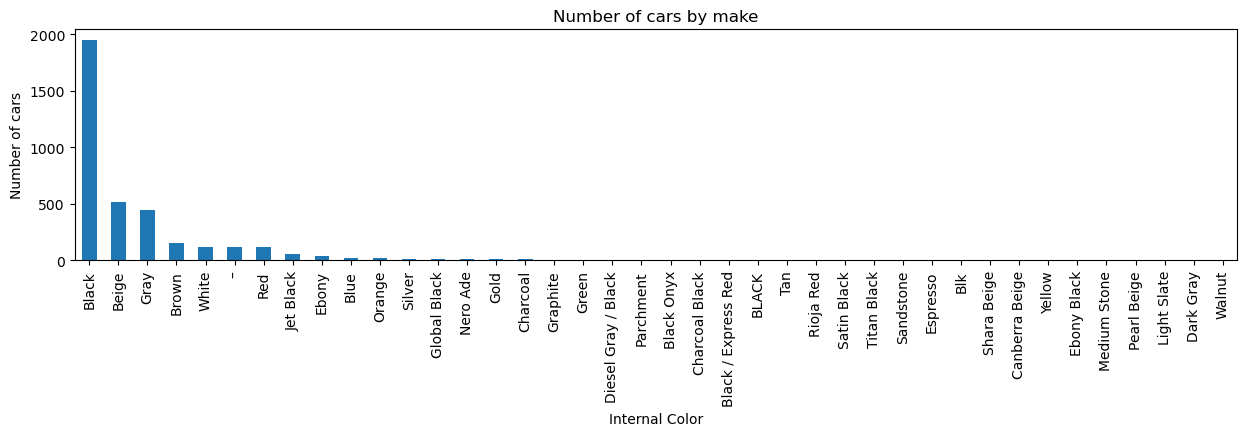

In [45]:
df['int_col'].value_counts().nlargest(40).plot(kind='bar', figsize=(15, 3))
plt.title("Number of cars by make")
plt.ylabel('Number of cars')
plt.xlabel('Internal Color')

In [46]:
le = LabelEncoder()
le.fit(df['fuel_type'])
le_make_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
df['fuel_type'] = le.transform(df['fuel_type'])

label_encodings_file.write("fuel_type: \n")
label_encodings_file.write(str(le_make_mapping))

97

In [47]:
le = LabelEncoder()
le.fit(df['accident'])
le_make_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
df['accident'] = le.transform(df['accident'])

label_encodings_file.write("\n\naccident: \n")
label_encodings_file.write(str(le_make_mapping))

65

In [48]:
def categorize_color(color):
    if "red" in color.lower():
        return "Red"
    elif "blue" in color.lower():
        return "Blue"
    elif "green" in color.lower():
        return "Green"
    elif "yellow" in color.lower():
        return "Yellow"
    elif "orange" in color.lower():
        return "Orange"
    elif "purple" in color.lower():
        return "Purple"
    elif "brown" in color.lower():
        return "Brown"
    elif "black" in color.lower():
        return "Black"
    elif "white" in color.lower():
        return "White"
    elif "gray" in color.lower() or "metallic" in color.lower() or "silver" in color.lower():
        return "Gray"
    else:
        return "Others"

In [49]:
df['ext_col'] = df['ext_col'].apply(lambda x: categorize_color(x))
df['int_col'] = df['int_col'].apply(lambda x: categorize_color(x))

In [50]:
le = LabelEncoder()
le.fit(df['brand'])
le_make_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
df['brand'] = le.transform(df['brand'])

label_encodings_file.write("\n\nbrand: \n")
label_encodings_file.write(str(le_make_mapping))

739

In [51]:
le = LabelEncoder()
le.fit(df['ext_col'])
le_make_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
df['ext_col'] = le.transform(df['ext_col'])

label_encodings_file.write("\n\next_col: \n")
label_encodings_file.write(str(le_make_mapping))

133

In [52]:
le = LabelEncoder()
le.fit(df['int_col'])
le_make_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
df['int_col'] = le.transform(df['int_col'])

label_encodings_file.write("\n\nint_col: \n")
label_encodings_file.write(str(le_make_mapping))

119

In [53]:
le = LabelEncoder()
le.fit(df['transmission_type'])
le_make_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
df['transmission_type'] = le.transform(df['transmission_type'])

label_encodings_file.write("\n\ntransmission_type: \n")
label_encodings_file.write(str(le_make_mapping))

53

In [54]:
price_map = {'very low': 0, 'low': 1, 'medium': 2, 'high': 3, 'very high': 4}
df['price'] = df['price'].map(price_map)

label_encodings_file.write("\n\nprice: \n")
label_encodings_file.write(str(price_map))

65

In [55]:
label_encodings_file.close()

In [56]:
# Convert all columns to numeric
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [57]:
df.dropna(inplace=True, how='any')

In [58]:
df.head()

,brand,model_year,milage,fuel_type,ext_col,int_col,accident,price,horsepower,displacement,cylinders,transmission_type,gears
0,13,2013,51000.0,1,0,0,0,0,300.0,3.7,6.0,0,6.0
1,18,2021,34742.0,3,6,3,0,1,240.0,3.8,6.0,0,8.0
2,25,2022,22372.0,3,1,0,1,2,301.0,3.5,6.0,0,8.0
3,19,2015,88900.0,4,0,0,1,0,354.0,3.5,6.0,0,7.0
4,3,2021,9835.0,3,9,0,1,1,333.0,2.0,4.0,0,8.0


In [59]:
df.to_csv('../clean_data/cars_usa_clean.csv', index=False)

,brand,model_year,milage,fuel_type,ext_col,int_col,accident,price,horsepower,displacement,cylinders,transmission_type,gears
brand,1.000000,0.010106,-0.012705,-0.002200,-0.027037,0.005391,0.022080,0.025780,-0.061085,-0.193391,-0.238708,0.070416,-0.201446
model_year,0.010106,1.000000,-0.642070,0.052224,-0.011998,-0.102285,0.213817,0.575464,0.264947,-0.179720,-0.174600,-0.233715,0.135943
milage,-0.012705,-0.642070,1.000000,-0.144443,-0.023914,0.079267,-0.303530,-0.635843,-0.317046,0.128977,0.082794,0.020290,-0.097105
fuel_type,-0.002200,0.052224,-0.144443,1.000000,-0.049919,0.000128,0.028734,0.020388,-0.078142,-0.137060,0.020345,0.082221,0.089688
ext_col,-0.027037,-0.011998,-0.023914,-0.049919,1.000000,0.130425,0.009965,-0.000735,-0.018363,0.014303,-0.011516,-0.027808,-0.014906
int_col,0.005391,-0.102285,0.079267,0.000128,0.130425,1.000000,-0.023209,-0.027336,0.017758,-0.014824,0.015265,-0.065407,-0.019431
accident,0.022080,0.213817,-0.303530,0.028734,0.009965,-0.023209,1.000000,0.258561,0.128581,-0.049740,-0.031504,0.003238,0.021496
price,0.025780,0.575464,-0.635843,0.020388,-0.000735,-0.027336,0.258561,1.000000,0.634610,0.174198,0.202976,-0.085887,0.140343
horsepower,-0.061085,0.264947,-0.317046,-0.078142,-0.018363,0.017758,0.128581,0.634610,1.000000,0.387017,0.390462,-0.111905,0.063471
displacement,-0.193391,-0.179720,0.128977,-0.137060,0.014303,-0.014824,-0.049740,0.174198,0.387017,1.000000,0.884646,-0.062929,0.192812


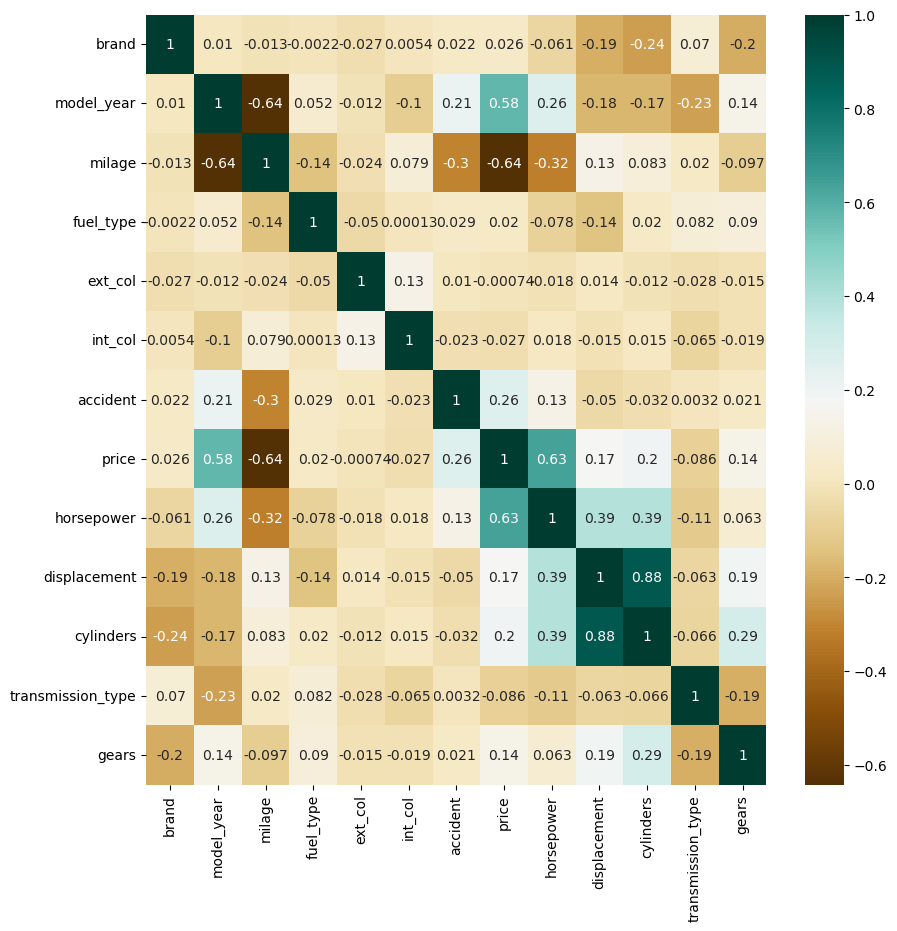

In [60]:
plt.figure(figsize=(10, 10))
corr_fig = df.corr()
sns.heatmap(corr_fig,cmap="BrBG",annot=True)
corr_fig